# Estudos sobre a base de descartes de materiais e ajustes manuais de inventário de estoques

Este trabalho se resume em garantir que existe um monitoramento das transações que são realizadas no estoque
via ERP.

Focamos nossas análises nas categorias de descarte e ajustes manuais de inventário por estes representarem um
risco à organização, tanto financeiro quanto reputacional.

As análises expressas nesta documentação têm cunho unicamente exploratório e descritivo, sendo que as análises principais
estão feitas paralelamente na ferramenta Power BI

In [5]:
# Importação das bibliotecas essenciais para o estudo

import pandas as pd
import numpy as np
from google.cloud import bigquery
from google.oauth2 import service_account

# Criação das variáveis de autenticação do BigQuery
credentials = service_account.Credentials.from_service_account_file('bigdataoswaldosirio-3bad48c014d7.json')
project_id = 'bigdataoswaldosirio'
client = bigquery.Client(credentials=credentials,project=project_id)

# Query de seleção dos dados
query_job = client.query("""
    SELECT 
      Fato.codMovEstoque,
      Fato.DocMaterial,
      Fato.ItemDOcMaterial,
      Fato.DataDocumento,
      Fato.Valor,
      Fato.UnidadeMedida,
      Fato.Quantidade,
      DimCC.CentroCusto,
      DimMat.NumMaterial,
      DimMat.DescMaterial,
      DimMat.MedControlado,
      DimMot.DescMotivo,
      DimTpM.TipoMovimento,
      DimTpM.DescMovimento
    FROM `bigdataoswaldosirio.Dimensional.FatoMovEstoque` as Fato
    LEFT JOIN `bigdataoswaldosirio.Dimensional.DimCentroCusto` as DimCC
     ON DimCC.codCentroCusto = Fato.codCentroCusto
    LEFT JOIN `bigdataoswaldosirio.Dimensional.DimMaterial` as DimMat
     ON DimMat.codMaterial = Fato.codMaterial
    LEFT JOIN `bigdataoswaldosirio.Dimensional.DimMotivoMovimento` as DimMot
     ON DimMot.codMotivo = Fato.codMotivo
    LEFT JOIN `bigdataoswaldosirio.Dimensional.DimTipoMovimento` as DimTpM
     ON DimTpM.codMovimento = Fato.codMovimento
""")

# Armazena os resultados da query e os transforma em um DataFrame, exibindo o inínio dos df
results = query_job.result()
estoques = results.to_dataframe()
estoques.head()

,codMovEstoque,DocMaterial,ItemDOcMaterial,DataDocumento,Valor,UnidadeMedida,Quantidade,CentroCusto,NumMaterial,DescMaterial,MedControlado,DescMotivo,TipoMovimento,DescMovimento
0,212743,4989943011,1,2019-04-10 00:00:00+00:00,-130.24,UN,-1.0,HEMO,208113,REAG SERIGRUP DIANA A1/B213659,Nao,Danificado no armazem,Descarte,SM sucata
1,236162,4992110440,1,2019-06-19 00:00:00+00:00,-591.00,UN,-2.0,HEMO,215687,ION REPROSEQ 318 VIEW A32250,Nao,Danificado no armazem,Descarte,SM sucata
2,1063,4992515178,1,2019-07-02 00:00:00+00:00,-9.32,UN,-4.0,FASC,100011,ANAFRANIL 25MG DG [CONTRC1] UNIT,Sim,Danificado no armazem,Descarte,SM sucata
3,1064,4984451687,1,2018-09-27 00:00:00+00:00,-69.94,UN,-20.0,FASC,100011,ANAFRANIL 25MG DG [CONTRC1] UNIT,Sim,Danificado no armazem,Descarte,SM sucata
4,1781,4988457374,1,2019-02-18 00:00:00+00:00,-11.45,UN,-3.0,FASC,100014,AROPAX 20MG CP [CONTROL C1] UNITE20,Sim,Danificado no armazem,Descarte,SM sucata


In [6]:
# Formato da base (linhas, colunas)
estoques.shape

(117208, 14)

In [7]:
# Análise exploratória dos dados
estoques.describe()

,codMovEstoque,DocMaterial,ItemDOcMaterial,Valor,Quantidade,NumMaterial
count,117208.000000,1.172080e+05,117208.000000,1.172080e+05,1.172080e+05,117208.000000
mean,122094.402396,4.985145e+09,12.877875,2.853161e+01,1.718457e+00,138127.899077
std,68656.833369,4.208557e+06,29.808715,2.460253e+06,4.285411e+06,54313.358859
min,1.000000,4.978386e+09,1.000000,-5.954945e+08,-1.037400e+09,100001.000000
25%,63465.750000,4.981393e+09,1.000000,-1.960000e+01,-3.000000e+00,101485.000000
50%,123502.500000,4.984807e+09,3.000000,-2.350000e+00,-1.000000e+00,104361.000000
75%,180777.250000,4.988474e+09,12.000000,1.046000e+01,1.000000e+00,202291.000000
max,238543.000000,4.993388e+09,430.000000,5.954945e+08,1.037400e+09,502040.000000


In [8]:
# Lista o formato dos campos 
estoques.dtypes

codMovEstoque                    int64
DocMaterial                      int64
ItemDOcMaterial                  int64
DataDocumento      datetime64[ns, UTC]
Valor                          float64
UnidadeMedida                   object
Quantidade                     float64
CentroCusto                     object
NumMaterial                      int64
DescMaterial                    object
MedControlado                   object
DescMotivo                      object
TipoMovimento                   object
DescMovimento                   object
dtype: object

In [9]:
# Realiza o ETL do campo de valor
estoques['ValorAbs'] = np.where(estoques['Valor']<0,estoques['Valor']*-1,estoques['Valor'])
estoques['EntradaSaida'] = np.where(estoques['Valor']<0,'Saída','Entrada')
estoques['EntradaSaida'].value_counts()

Saída      76582
Entrada    40626
Name: EntradaSaida, dtype: int64

In [10]:
# Realiza o ajuste do formato de visualização de variáveis float e realiza uma agregação por descrição do motivo do movimento
pd.options.display.float_format = 'R${:,.2f}'.format
estoques.groupby('DescMotivo')['Valor'].agg(['sum', 'count'])

,sum,count
DescMotivo,,
Compra ou utilizacao de material sem vinculo automatico,"R$-2,224,440.19",61477
Danificado no armazem,"R$-3,511,223.82",32335
Danificado no manuseio,"R$-52,158.75",294
Danificado no transporte,"R$-23,003.45",522
Erro no cadastro da unidade de medida,"R$-65,539.66",1511
Expiracao da validade,"R$-41,117.82",13943
Solicitacao da diretoria,"R$9,261,617.21",7126


In [18]:
# Realiza o agrupamento por materiais

estoques.groupby(['NumMaterial','TipoMovimento'])['Valor'].agg(['sum', 'count'])

sum  count
NumMaterial TipoMovimento                   
100001      Ajuste           R$-21.82     17
            Descarte         R$-39.36     30
100002      Ajuste           R$-43.92     12
            Descarte         R$-34.76      2
100003      Ajuste           R$-40.44     11
...                               ...    ...
501780      Ajuste           R$238.00      1
501872      Ajuste          R$-144.00      1
502000      Ajuste         R$2,056.20      1
502011      Ajuste        R$-2,056.20      1
502040      Ajuste           R$-19.93      1

[8248 rows x 2 columns]

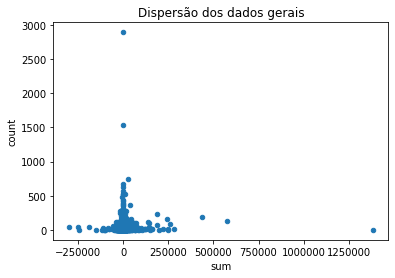

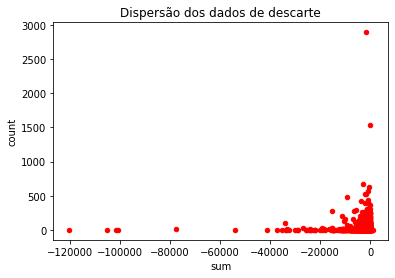

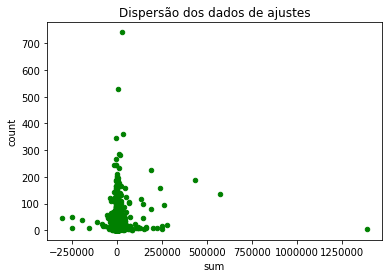

In [48]:
# Monta gráficos de dispersão para análise do comportamento dos dados

import matplotlib as plt
%matplotlib inline

estoques_descartes = estoques[estoques['TipoMovimento']=='Descarte']
estoques_ajuste = estoques[estoques['TipoMovimento']=='Ajuste']

estoques.groupby(['NumMaterial','TipoMovimento'])['Valor'].agg(['sum', 'count']).plot.scatter(x='sum', y='count', title='Dispersão dos dados gerais')
estoques_descartes.groupby(['NumMaterial','TipoMovimento'])['Valor'].agg(['sum', 'count']).plot.scatter(x='sum', y='count', c='red', title='Dispersão dos dados de descarte')
estoques_ajuste.groupby(['NumMaterial','TipoMovimento'])['Valor'].agg(['sum', 'count']).plot.scatter(x='sum', y='count', c='green', title='Dispersão dos dados de ajustes')
#t = estoques_agg[estoques_agg['TipoMovimento']=='Descarte']
#estoques.groupby(['NumMaterial','TipoMovimento'])['Valor'].agg(['sum', 'count']).plot.scatter(x='sum', y='count')
#estoques.groupby(['NumMaterial','TipoMovimento'])['Valor'].agg(['sum', 'count']).plot.scatter(x='sum', y='count')

#estoques_materiais = estoques.groupby(['NumMaterial','TipoMovimento'])['Valor'].agg(['sum', 'count'])

#def alert(c):
#  if c['TipoMovimento'] == 'Descarte':
#    return 0
#  elif c['TipoMovimento'] == 'Ajuste':
#    return 1
#  else:
#    return 9

#estoques_materiais['TipoMovimento'] = estoques_materiais.apply(alert,axis=1)

#estoques_materiais['TipoMovimentoNum'] = list(np.where(estoques_materiais['TipoMovimento']=='Descartes',0,1))
#estoques_materiais.head()
#estoques_materiais.plot.scatter(x='sum', y='count', c=estoques_materiais['TipoMovimento'].map(colors))
#estoques_materiais.plot.scatter(x='sum', y='count')

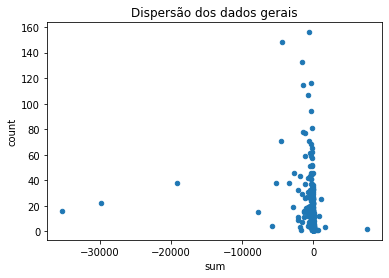

In [55]:
# Análise do comportamento dos medicamentos controlados

estoques_controlados = estoques[estoques['MedControlado']=='Sim']
estoques_controlados.groupby(['NumMaterial','TipoMovimento'])['Valor'].agg(['sum', 'count']).plot.scatter(x='sum', y='count', title='Dispersão dos dados gerais')